1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

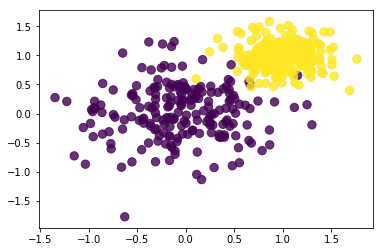

In [2]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import integrate
import scipy
from matplotlib.ticker import MultipleLocator
Image('two_categories_scatter_plot.png')

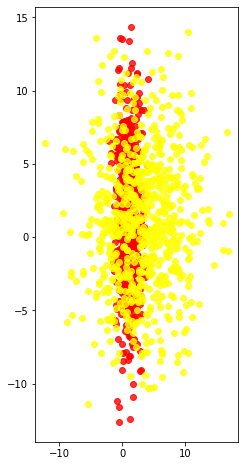

In [17]:
def generator(means, covs, samples):
    A1, B1 = np.random.multivariate_normal(means[0], covs[0], samples).T
    A2, B2 = np.random.multivariate_normal(means[1], covs[1], samples).T
    return A1, A2 ,B1 , B2

means = ([1, 1], [3, 1])
covs = ([[1, 0], [0, 18]], [[20, 0], [0, 20]])
samples = 700

A1, A2, B1, B2 = generator(means, covs, samples)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(121)
ax.scatter(A1, B1, color = 'red', alpha=0.8)
ax.scatter(A2, B2, color = 'yellow', alpha=0.8)
plt.show()

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [9]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

--2021-12-02 03:24:43--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2021-12-02 03:24:43--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdd1f9973b3536544a432e9f12b.dl.dropboxusercontent.com/cd/0/inline/BbDpovk2QXuD21b20E7ZW6sybGjumhpWd5s9C9NpnmdzLj2c60mh50OpD6qG4zEgEca5671pagBoVW4iml0tY-qWpTbhWkbPlxOwNzT9cWi76-VNWMAFZRUoGFAVnthIRdEVYx5FWS7EF7rlaKtehkOP/file# [following]
--2021-12-02 03:24:43--  https://ucdd1f9973b3536544a432e9f12b.dl.dropboxusercontent.com/cd/0/inline/BbDpovk2QXuD21b20E7ZW6sybGjumhpWd5s9C9NpnmdzLj2c60mh50OpD6qG4zEgEca5671p

,residuals,distances
0,1.10,16.0
1,-1.95,6.3
2,-7.20,3.4
3,-4.15,8.4
4,-6.59,1.7


,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0


/home/mhm/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


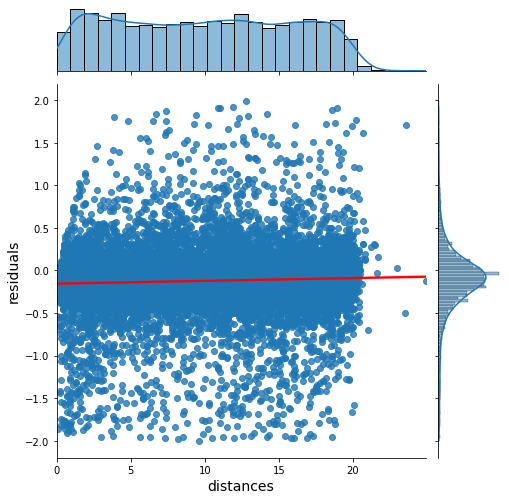

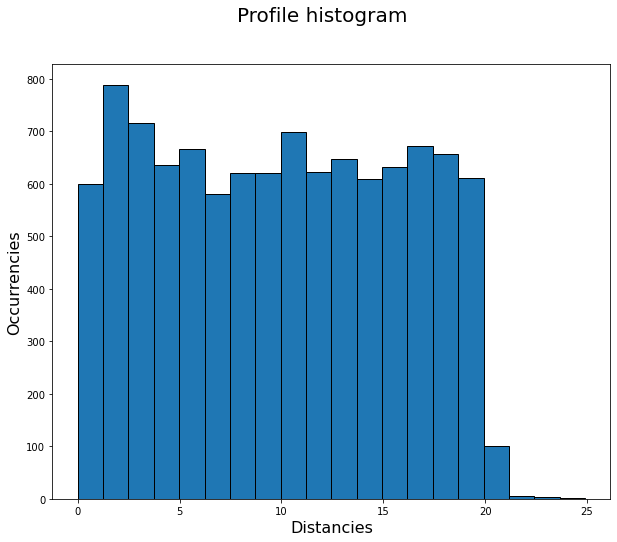

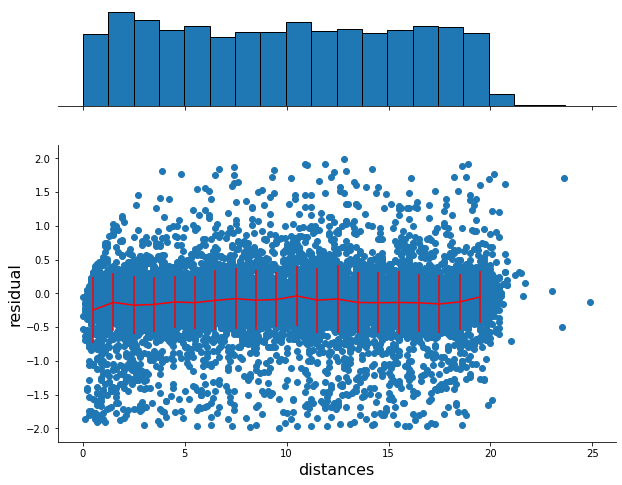

In [16]:
from IPython.display import display

data = np.load('data/residuals_261.pkl', allow_pickle = "true").item()

data = pd.DataFrame(data)
display(data.head())
print('\n')

data = data[data['residuals'].abs() < 2]
display(data.head())

g = sns.jointplot('distances', 'residuals',  data, kind = 'reg', joint_kws={'line_kws':{'color':'red'}}, height = 7)
g.set_axis_labels('distances', 'residuals', fontsize = 14)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.hist(data['distances'], bins = 20, edgecolor = "black")
fig.suptitle('Profile', fontsize = 20)
ax.set_xlabel('Distancies', fontsize = 16)
ax.set_ylabel('Occurrencies', fontsize = 16)
plt.show()

# Numpy arrays
_, bins = np.histogram(data['distances'], bins = 20, range=[0,20])
x = 0.5*(bins[1:]+bins[:-1])
y = np.array([data.loc[(data['distances'] >= bins[i]) & (data['distances'] < bins[i+1])]['residuals'].mean() for i in range(len(bins)-1)])
err_y = np.array([data.loc[(data['distances'] >= bins[i]) & (data['distances'] < bins[i+1])]['residuals'].std() for i in range(len(bins)-1)])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8), gridspec_kw={'height_ratios': [1, 3]})

ax1.hist(data['distances'], bins = 20, edgecolor = "black")
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_yticks([])
ax1.get_xaxis().set_ticklabels([])

ax2.scatter(data['distances'], data['residuals'], label = 'Data point')
ax2.errorbar(x, y, err_y, color = 'red')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('distances', fontsize = 16)
ax2.set_ylabel('residual', fontsize = 16)
plt.show()

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


<ipython-input-17-e67aac718f64>:10: RuntimeWarning: divide by zero encountered in true_divide
  err_y = 1/np.sqrt(y)


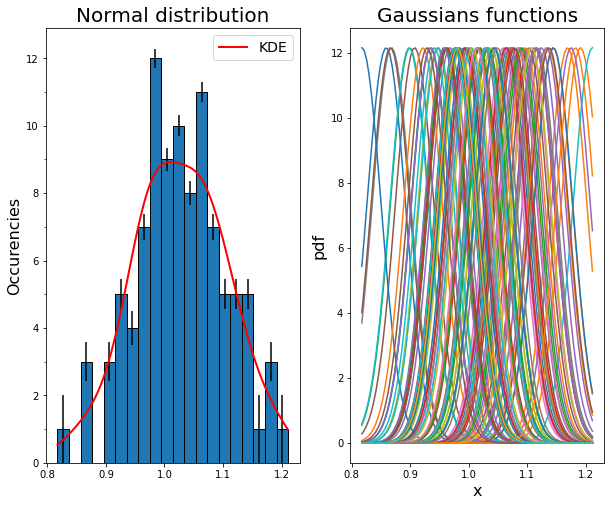

In [17]:
mean = 1
std = 0.1
samples = 100
x = np.random.normal(mean, std, samples)

#Histogram plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,8))
y, bins, patches = ax1.hist(x, 20, edgecolor = 'black')
center_bins = 0.5*(bins[1:]+bins[:-1])
err_y = 1/np.sqrt(y)
ax1.set_ylabel("")
ax1.errorbar(center_bins, y, err_y, color = 'black',  fmt = 'none')
ax1.set_ylabel('Occurencies', fontsize = 16)
ax1.set_title('Normal distribution', fontsize = 20)
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(2))

# Gaussian   
gaussian=[]
grid = np.linspace(x.min(), x.max(), samples) #return N points evenly-spaced
    
for item in x:
    std = 1.06*x.std()*x.size**(-0.2)
    gauss = norm.pdf(grid, item, std) #gauss of N-points, mean=item, std=stddev
    gaussian.append(gauss)
    ax2.plot(grid, gauss)

ax2.set_title('Gaussians functions', fontsize = 20)
ax2.set_xlabel("x", fontsize = 16)
ax2.set_ylabel('pdf', fontsize = 16)

#Gaussian sum and normalization
gaussian_sum = np.sum(gaussian, axis = 0)
gaussian_norm = np.trapz(np.sum(gaussian,axis=0),grid)/np.trapz(y, x = center_bins)
normalized_sum = gaussian_sum/gaussian_norm 
ax1.plot(grid, normalized_sum, label = 'KDE', color = 'red', linewidth = 2)
ax1.legend(fontsize = 14)